In [1]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
from mplsoccer import VerticalPitch,FontManager,add_image
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors
from urllib.request import urlopen
from PIL import Image

from matplotlib.patches import Circle, Rectangle, Arc

In [2]:
xT = pd.read_csv("/work/assets/xT_Grid.csv")
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

In [7]:
dfS = []
for i in range(1,39):
#     df= pd.read_csv(f"/work/assets/whoscored/euro2020/2122#{sources[i]}.csv")
    df= pd.read_csv(f"/work/assets/whoscored/wolves/match/1920/eventsData/new/1920#{i}.csv")

    dfS.append(df)


dfB = []
for i in range(1,39):
#     df= pd.read_csv(f"/work/assets/whoscored/barcelona/match/2122/eventsData/2122#{i}.csv")
    df = pd.read_csv(f"/work/assets/whoscored/wolves/match/2021/eventsData/new/2021#{i}.csv")
    dfB.append(df)
# dfC= pd.read_csv(f"/work/assets/whoscored/barcelona/match/2122/eventsData/2122#cl_bayernH.csv")
# dfL= pd.read_csv(f"/work/assets/whoscored/barcelona/match/2122/eventsData/2122#cl_benficaA.csv")
# dfB.append(dfC)
# dfB.append(dfL)

    
def get_angle(val):
        x1, y1, x2, y2 = val
        dx = x2 - x1
        dy = y2 - y1
        result = np.arctan2(dy, dx)
        return result if result>=0 else result + 2*np.pi

#Angle Multiplier
multiplier = 2*np.pi/24

def setup(dfs):

    df = pd.concat(dfs)
    not_sub = df['type']!='SubstitutionOn'
    df = df[not_sub]

    #Filter Pass
    df['x']=df['x']*1.2
    df['endX']=df['endX']*1.2
    df['y']=df['y']*0.8
    df['endY']=df['endY']*0.8
    df["y"] = 80 - df["y"]
    df["endY"] = 80 - df["endY"]
    
    df=df[((df['type']=="Pass") & (df['outcomeType']=="Successful"))]
    df['playerId'] = df['playerId'].astype(int)
    df = df.dropna(subset=['playerId'],axis=0)

    df['length'] = np.sqrt(np.square(df["x"] - df["endX"]) + np.square(df["y"] - df["endY"]))
    # df['angle'] = df[['x', 'y', 'endX', 'endY']].apply(get_angle, axis=1)
    df['angle'] = df[['y', 'x', 'endY', 'endX']].apply(get_angle, axis=1)
    df['angle_bin'] = pd.cut(df['angle'], bins=np.linspace(0, 2*np.pi, 25), right=True, labels=False)
    
    
    #Bin Data for xT

    # We use a pandas method called .cut --> https://pandas.pydata.org/docs/reference/api/pandas.cut.html
    # We say labels=False because we want the integer locator of the bin
    df['x_bin'] = pd.cut(df['x'], bins=xT_cols, labels=False)
    df['y_bin'] = pd.cut(df['y'], bins=xT_rows, labels=False)
    df['endX_bin'] = pd.cut(df['endX'], bins=xT_cols, labels=False)
    df['endY_bin'] = pd.cut(df['endY'], bins=xT_rows, labels=False)

    # Return Bin Values for xT
    # We use a lambda function to assign the values from the bins to the x and y values with numpy array slicing
    # it is going through each row and assigning the values based on where those numbers are in the numpy array
    # kind of an advanced topic, so be sure to familiarize yourself with slicing and indexing
    # its basically doing this: xT[4][5] where 4 is the fourth list and 5 is the fifth item in that list

    df['start_zone_value'] = df[['x_bin', 'y_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)
    df['end_zone_value'] = df[['endX_bin', 'endY_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)

    # now we find the difference between the start and end to get the xT value
    df['xT'] = df['end_zone_value'] - df['start_zone_value']
    
    return df

In [8]:
dfSpain = setup(dfS)

In [9]:
dfBarca = setup(dfB)

In [10]:
textColor = "#ededed"
#Set cmap
# cmap1 = plt.cm.get_cmap('Oranges')
# cmap2 = plt.cm.get_cmap('Reds')
cmap = colors.LinearSegmentedColormap.from_list("", ["seagreen", "orange", 'crimson'])
cmap2 = colors.LinearSegmentedColormap.from_list("", ["blue", "yellow", 'green'])
cmap1 = mpl.colors.LinearSegmentedColormap.from_list('cmap', ["#13B9D6","#D61327"])


614
median:  16.204045514254112
std:  3.9912509479769707
var:  15.930084129727067
passcount sum:  23.941368078175895
xT sum:  28.006437375
xT sum:  15.557116
614
median:  16.204045514254112
std:  3.9912509479769707
var:  15.930084129727067
passcount sum:  23.941368078175895
xT sum:  28.006437375
xT sum:  15.557116


[Text(0.0, 0, 'Right'),
 Text(0.7853981633974483, 0, ''),
 Text(1.5707963267948966, 0, 'Forward'),
 Text(2.356194490192345, 0, ''),
 Text(3.141592653589793, 0, 'Left'),
 Text(3.9269908169872414, 0, ''),
 Text(4.71238898038469, 0, 'Back'),
 Text(5.497787143782138, 0, '')]

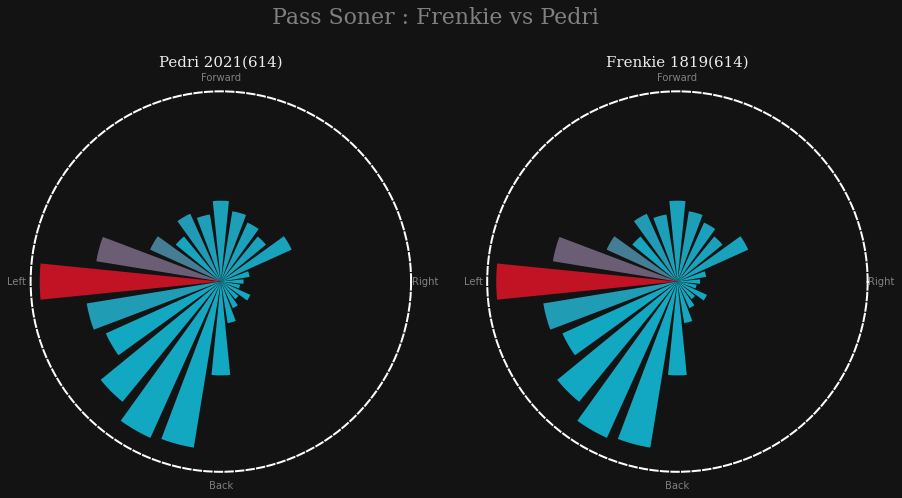

In [12]:
fig,axes = plt.subplots(1,2,figsize=(15,8),subplot_kw={'projection': 'polar'})
fig.set_facecolor("#131313")
fig.suptitle("Pass Soner : Frenkie vs Pedri", fontsize=22, fontname="serif", color="gray")
# fig.text(x=0.42,y=0.84,s="Spain vs Barcelona",fontsize=19, color="gray", fontname="serif")
axes = axes.ravel()

def plotSoner(df,playerId,playerName,x,myCmap):
    df = df[df["playerId"]==playerId]
    ALLPASS = len(df)
    print(ALLPASS)
    VC = df["angle_bin"].value_counts()
    VARTICALPASS = 0
    for i in VC.index:
        if (0 < i < 0.8)|(5.6 < i < 7)|(11.9 < i < 13.26)|(18.16 < i < 19.5):
            VARTICALPASS += VC[i]
    
    result = np.round(VARTICALPASS/ALLPASS*100,2)
    pdf = df.groupby(
        ['playerId', 'angle_bin']).agg(count = ('angle_bin', 'count'),
                                       avg_length = ('length', 'mean'), 
                                       xT = ("xT","sum")).reset_index()
    pdf["xT"] = pdf["xT"]*100

    colors = myCmap(pdf['xT'] / pdf['xT'].max())
    
    print("median: ",pdf.loc[:,"avg_length"].median())
    print("std: ",pdf.loc[:,"avg_length"].std())
    print("var: ",pdf.loc[:,"avg_length"].var())
    
    
    
    axes[x].set_facecolor("#131313")
    axes[x].set_xticklabels([])
    axes[x].set_yticks([])
    axes[x].grid(False, alpha=0)
    axes[x].spines['polar'].set_visible(True)
    axes[x].spines['polar'].set_color("white")
    axes[x].spines['polar'].set_linestyle("--")
    axes[x].spines['polar'].set_linewidth("2")
    
    axes[x].patch.set_alpha(1)
    axes[x].bar(pdf['angle_bin']*multiplier, 
                pdf['count'], 
                width=0.2, bottom=0, 
                alpha=0.9, color=colors, zorder=3)
    axes[x].set_title(f"{playerName}({ALLPASS})",y=1.05,fontsize=15, fontname="serif",color=textColor)
    
    values = df["angle_bin"].value_counts().sort_index().values
    sums = df["angle_bin"].value_counts().sum()
    bar = (values/sums) *100
    print("passcount sum: ",bar[3:10].sum())
    
    dd = pdf.set_index("angle_bin")
    print("xT sum: ",dd.loc[3.0:10.0, "xT"].mean())
    print("xT sum: ",dd.loc[3.0, "xT"].sum())
    

plotSoner(dfSpain,140088,"Pedri 2021",0, cmap1)
plotSoner(dfSpain,140088,"Frenkie 1819",1, cmap1)

# axes[0].text(4,69.7,
#          "\n- Bar Length is representive of Pass Frequency\
#          \n- Bar Direction is representive Pass Direction\
#          \n- Bar Color is representive of xT green(small chance) -> red(big chance)", 
#          fontsize=10,color="#ededed")

axes[0].set_xticklabels(["Right","","Forward","","Left","","Back",""],color="gray")
axes[1].set_xticklabels(["Right","","Forward","","Left","","Back",""],color="gray")


# plt.savefig(f'/work/output/pedri2021frenkie2021.png', dpi=100, bbox_inches="tight",facecolor='#131313')

In [18]:
print(axes[1].get_ybound())
print(axes[1].get_xbound())

(0.0, 15.75)
(0.0, 6.283185307179586)


In [7]:
values = dfBarca["angle_bin"].value_counts().sort_index().values
print(values)
sums = dfBarca["angle_bin"].value_counts().sum()
bar = (values/sums) *100
bar[2:10].sum()

[351 357 354 278 213 286 293 274 305 363 440 368 330 298 213 202 199 195
 172 201 208 240 246 316]


35.30289465831095

In [8]:
dfBarca = dfBarca[dfBarca["playerId"]==402197]
values = dfBarca["angle_bin"].value_counts().reset_index().sort_values("index")

# print(values)
# bar % 
values["angle_bin"] = values["angle_bin"]/values["angle_bin"].sum() * 100
values_per = values.set_index("index")
# print(values_per)
front = values_per["angle_bin"][0:10].sum()
moreFront = values_per["angle_bin"][3:7].sum()
right = values_per["angle_bin"][0:5].sum()
left = values_per["angle_bin"][6:10].sum()
print(front, moreFront, right, left)



# print(values)
# sums = dfBarca["xT"].value_counts().sum()
# print(sums)
# bar = (values/sums) *100

48.42767295597484 9.433962264150942 22.012578616352204 26.41509433962264


In [121]:
values_per["angle_bin"][0:5]/values_per["angle_bin"][0:5].sum()*100

index
0.0    20.000000
1.0    40.000000
2.0    14.285714
3.0    11.428571
4.0     8.571429
5.0     5.714286
Name: angle_bin, dtype: float64

In [9]:
dfSpain = dfSpain[dfSpain["playerId"]==402197]
values = dfSpain["angle_bin"].value_counts().reset_index().sort_values("index")

values["angle_bin"] = values["angle_bin"]/values["angle_bin"].sum() * 100
values_per = values.set_index("index")
# print(values_per)
front = values_per["angle_bin"][0:10].sum()
moreFront = values_per["angle_bin"][3:7].sum()
right = values_per["angle_bin"][0:5].sum()
left = values_per["angle_bin"][6:10].sum()
print(front, moreFront, right, left)


# bar % 
# values_per = values/values.sum() * 100
# values_per[0:13].sum()

47.05882352941177 13.411764705882355 18.352941176470587 28.705882352941178


In [116]:
values_per["angle_bin"][0:5]/right*100

index
0.0    17.431193
1.0    17.431193
2.0    12.844037
3.0     6.422018
4.0     4.587156
5.0    12.844037
Name: angle_bin, dtype: float64

In [55]:
dd = dfBarca.groupby(
    ["playerId","angle_bin"]).agg(count = ('angle_bin', 'count'),
                                       avg_length = ('length', 'mean'), 
                                       xT = ("xT","sum")).reset_index()

dd = dd.set_index("angle_bin")
dd.loc[2.0:10.0, "xT"].sum()

0.46426156

In [30]:
values = dfSpain["angle_bin"].value_counts().sort_index().values
sums = dfSpain["angle_bin"].value_counts().sum()
spe = (values/sums) *100
spe[2:10].sum()

32.50843644544432

In [6]:
dfBarca["angle_bin"].value_counts().sort_index()

0.0     351
1.0     357
2.0     354
3.0     278
4.0     213
5.0     286
6.0     293
7.0     274
8.0     305
9.0     363
10.0    440
11.0    368
12.0    330
13.0    298
14.0    213
15.0    202
16.0    199
17.0    195
18.0    172
19.0    201
20.0    208
21.0    240
22.0    246
23.0    316
Name: angle_bin, dtype: int64

In [8]:
sums

6702

In [5]:
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as path_effects
import numpy as np

from scipy.spatial import Voronoi
from shapely.geometry import Polygon

X_SIZE = 105
Y_SIZE = 68

BOX_HEIGHT = (16.5*2 + 7.32)/Y_SIZE*100
BOX_WIDTH = 16.5/X_SIZE*100

GOAL = 7.32/Y_SIZE*100

GOAL_AREA_HEIGHT = 5.4864*2/Y_SIZE*100 + GOAL
GOAL_AREA_WIDTH = 5.4864/X_SIZE*100

SCALERS = np.array([X_SIZE/100, Y_SIZE/100])
pitch_polygon = Polygon(((0,0), (0,100), (100,100), (100,0)))

def draw_pitch(dpi=100, pitch_color='#a8bc95'):
    """Sets up field
    Returns matplotlib fig and axes objects.
    """
    fig = plt.figure(figsize=(12.8, 7.2), dpi=dpi)
    fig.patch.set_facecolor(pitch_color)

    axes = fig.add_subplot(1, 1, 1)
    axes.set_axis_off()
    axes.set_facecolor(pitch_color)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)

    axes.set_xlim(0,100)
    axes.set_ylim(0,100)

    plt.xlim([-13.32, 113.32])
    plt.ylim([-5, 105])

    fig.tight_layout(pad=3)

    draw_patches(axes)

    return fig, axes

def draw_patches(axes):
    """
    Draws basic field shapes on an axes
    """
    #pitch
    axes.add_patch(plt.Rectangle((0, 0), 100, 100,
                       edgecolor="white", facecolor="none"))

    #half-way line
    axes.add_line(plt.Line2D([50, 50], [100, 0],
                    c='w'))

    #penalty areas
    axes.add_patch(plt.Rectangle((100-BOX_WIDTH, (100-BOX_HEIGHT)/2),  BOX_WIDTH, BOX_HEIGHT,
                       ec='w', fc='none'))
    axes.add_patch(plt.Rectangle((0, (100-BOX_HEIGHT)/2),  BOX_WIDTH, BOX_HEIGHT,
                               ec='w', fc='none'))

    #goal areas
    axes.add_patch(plt.Rectangle((100-GOAL_AREA_WIDTH, (100-GOAL_AREA_HEIGHT)/2),  GOAL_AREA_WIDTH, GOAL_AREA_HEIGHT,
                       ec='w', fc='none'))
    axes.add_patch(plt.Rectangle((0, (100-GOAL_AREA_HEIGHT)/2),  GOAL_AREA_WIDTH, GOAL_AREA_HEIGHT,
                               ec='w', fc='none'))

    #goals
    axes.add_patch(plt.Rectangle((100, (100-GOAL)/2),  1, GOAL,
                       ec='w', fc='none'))
    axes.add_patch(plt.Rectangle((0, (100-GOAL)/2),  -1, GOAL,
                               ec='w', fc='none'))


    #halfway circle
    axes.add_patch(Ellipse((50, 50), 2*9.15/X_SIZE*100, 2*9.15/Y_SIZE*100,
                                    ec='w', fc='none'))

    return axes

def draw_frame(df, t, dpi=100, fps=20, display_num=False, display_time=False, show_players=True,
               highlight_color=None, highlight_player=None, shadow_player=None, text_color='white', flip=False, **anim_args):
    """
    Draws players from time t (in seconds) from a DataFrame df
    """
    fig, ax = draw_pitch(dpi=dpi)

    dfFrame = get_frame(df, t, fps=fps)
 
    if show_players:
        for pid in dfFrame.index:
            if pid==0:
                #se for bola
                try:
                    z = dfFrame.loc[pid]['z']
                except:
                    z = 0
                size = 1.2+z
                lw = 0.9
                color='black'
                edge='white'
                zorder = 100
            else:
                #se for jogador
                size = 3
                lw = 2
                edge = dfFrame.loc[pid]['edgecolor']

                if pid == highlight_player:
                    color = highlight_color
                else:
                    color = dfFrame.loc[pid]['bgcolor']
                if dfFrame.loc[pid]['team']=='attack':
                    zorder = 21
                else:
                    zorder = 20

            ax.add_artist(Ellipse((dfFrame.loc[pid]['x'],
                                dfFrame.loc[pid]['y']),
                                size/X_SIZE*100, size/Y_SIZE*100,
                                edgecolor=edge,
                                linewidth=lw,
                                facecolor=color,
                                alpha=0.8,
                                zorder=zorder))

            try:
                s = str(int(dfFrame.loc[pid]['player_num']))
            except ValueError:
                s = ''
            text = plt.text(dfFrame.loc[pid]['x'],dfFrame.loc[pid]['y'],s,
                            horizontalalignment='center', verticalalignment='center',
                            fontsize=8, color=text_color, zorder=22, alpha=0.8)

            text.set_path_effects([path_effects.Stroke(linewidth=1, foreground=text_color, alpha=0.8),
                                path_effects.Normal()])
            
    return fig, ax, dfFrame

def add_voronoi_to_fig(fig, ax, dfFrame):
    polygons = {}
    vor, dfVor = calculate_voronoi(dfFrame)
    for index, region in enumerate(vor.regions):
        if not -1 in region:
            if len(region)>0:
                try:
                    pl = dfVor[dfVor['region']==index]
                    polygon = Polygon([vor.vertices[i] for i in region]/SCALERS).intersection(pitch_polygon)
                    polygons[pl.index[0]] = polygon
                    color = pl['bgcolor'].values[0]
                    x, y = polygon.exterior.xy
                    plt.fill(x, y, c=color, alpha=0.30)
                except IndexError:
                    pass
                except AttributeError:
                    pass

    plt.scatter(dfVor['x'], dfVor['y'], c=dfVor['bgcolor'], alpha=0.2)

    return fig, ax, dfFrame

def calculate_voronoi(dfFrame):
    dfTemp = dfFrame.copy().drop(0, errors='ignore')

    values = np.vstack((dfTemp[['x', 'y']].values*SCALERS,
                        [-1000,-1000],
                        [+1000,+1000],
                        [+1000,-1000],
                        [-1000,+1000]
                       ))

    vor = Voronoi(values)

    dfTemp['region'] = vor.point_region[:-4]

    return vor, dfTemp

def get_frame(df, t, fps=20):
    dfFrame = df.loc[int(t*fps)].set_index('player')
    dfFrame.player_num = dfFrame.player_num.fillna('')
    return dfFrame

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 25 17:32:00 2020
@author: davsu428
"""
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

def createPitch(length,width, unity,linecolor): # in meters
    # Code by @JPJ_dejong

    """
    creates a plot in which the 'length' is the length of the pitch (goal to goal).
    And 'width' is the width of the pitch (sideline to sideline). 
    Fill in the unity in meters or in yards.
    """
    #Set unity
    if unity == "meters":
        # Set boundaries
        if length >= 120.5 or width >= 75.5:
            return(str("Field dimensions are too big for meters as unity, didn't you mean yards as unity?\
                       Otherwise the maximum length is 120 meters and the maximum width is 75 meters. Please try again"))
        #Run program if unity and boundaries are accepted
        else:
            #Create figure
            fig=plt.figure()
            #fig.set_size_inches(7, 5)
            ax=fig.add_subplot(1,1,1)
           
            #Pitch Outline & Centre Line
            plt.plot([0,0],[0,width], color=linecolor)
            plt.plot([0,length],[width,width], color=linecolor)
            plt.plot([length,length],[width,0], color=linecolor)
            plt.plot([length,0],[0,0], color=linecolor)
            plt.plot([length/2,length/2],[0,width], color=linecolor)
            
            #Left Penalty Area
            plt.plot([16.5 ,16.5],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
            plt.plot([0,16.5],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
            plt.plot([16.5,0],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)
            
            #Right Penalty Area
            plt.plot([(length-16.5),length],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
            plt.plot([(length-16.5), (length-16.5)],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
            plt.plot([(length-16.5),length],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)
            
            #Left 5-meters Box
            plt.plot([0,5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
            plt.plot([5.5,5.5],[(width/2+7.32/2+5.5),(width/2-7.32/2-5.5)],color=linecolor)
            plt.plot([5.5,0.5],[(width/2-7.32/2-5.5),(width/2-7.32/2-5.5)],color=linecolor)
            
            #Right 5 -eters Box
            plt.plot([length,length-5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
            plt.plot([length-5.5,length-5.5],[(width/2+7.32/2+5.5),width/2-7.32/2-5.5],color=linecolor)
            plt.plot([length-5.5,length],[width/2-7.32/2-5.5,width/2-7.32/2-5.5],color=linecolor)
            
            #Prepare Circles
            centreCircle = plt.Circle((length/2,width/2),9.15,color=linecolor,fill=False)
            centreSpot = plt.Circle((length/2,width/2),0.8,color=linecolor)
            leftPenSpot = plt.Circle((11,width/2),0.8,color=linecolor)
            rightPenSpot = plt.Circle((length-11,width/2),0.8,color=linecolor)
            
            #Draw Circles
            ax.add_patch(centreCircle)
            ax.add_patch(centreSpot)
            ax.add_patch(leftPenSpot)
            ax.add_patch(rightPenSpot)
            
            #Prepare Arcs
            leftArc = Arc((11,width/2),height=18.3,width=18.3,angle=0,theta1=308,theta2=52,color=linecolor)
            rightArc = Arc((length-11,width/2),height=18.3,width=18.3,angle=0,theta1=128,theta2=232,color=linecolor)
            
            #Draw Arcs
            ax.add_patch(leftArc)
            ax.add_patch(rightArc)
            #Axis titles

    #check unity again
    elif unity == "yards":
        #check boundaries again
        if length <= 95:
            return(str("Didn't you mean meters as unity?"))
        elif length >= 131 or width >= 101:
            return(str("Field dimensions are too big. Maximum length is 130, maximum width is 100"))
        #Run program if unity and boundaries are accepted
        else:
            #Create figure
            fig=plt.figure()
            #fig.set_size_inches(7, 5)
            ax=fig.add_subplot(1,1,1)
           
            #Pitch Outline & Centre Line
            plt.plot([0,0],[0,width], color=linecolor)
            plt.plot([0,length],[width,width], color=linecolor)
            plt.plot([length,length],[width,0], color=linecolor)
            plt.plot([length,0],[0,0], color=linecolor)
            plt.plot([length/2,length/2],[0,width], color=linecolor)
            
            #Left Penalty Area
            plt.plot([18 ,18],[(width/2 +18),(width/2-18)],color=linecolor)
            plt.plot([0,18],[(width/2 +18),(width/2 +18)],color=linecolor)
            plt.plot([18,0],[(width/2 -18),(width/2 -18)],color=linecolor)
            
            #Right Penalty Area
            plt.plot([(length-18),length],[(width/2 +18),(width/2 +18)],color=linecolor)
            plt.plot([(length-18), (length-18)],[(width/2 +18),(width/2-18)],color=linecolor)
            plt.plot([(length-18),length],[(width/2 -18),(width/2 -18)],color=linecolor)
            
            #Left 6-yard Box
            plt.plot([0,6],[(width/2+7.32/2+6),(width/2+7.32/2+6)],color=linecolor)
            plt.plot([6,6],[(width/2+7.32/2+6),(width/2-7.32/2-6)],color=linecolor)
            plt.plot([6,0],[(width/2-7.32/2-6),(width/2-7.32/2-6)],color=linecolor)
            
            #Right 6-yard Box
            plt.plot([length,length-6],[(width/2+7.32/2+6),(width/2+7.32/2+6)],color=linecolor)
            plt.plot([length-6,length-6],[(width/2+7.32/2+6),width/2-7.32/2-6],color=linecolor)
            plt.plot([length-6,length],[(width/2-7.32/2-6),width/2-7.32/2-6],color=linecolor)
            
            #Prepare Circles; 10 yards distance. penalty on 12 yards
            centreCircle = plt.Circle((length/2,width/2),10,color=linecolor,fill=False)
            centreSpot = plt.Circle((length/2,width/2),0.8,color=linecolor)
            leftPenSpot = plt.Circle((12,width/2),0.8,color=linecolor)
            rightPenSpot = plt.Circle((length-12,width/2),0.8,color=linecolor)
            
            #Draw Circles
            ax.add_patch(centreCircle)
            ax.add_patch(centreSpot)
            ax.add_patch(leftPenSpot)
            ax.add_patch(rightPenSpot)
            
            #Prepare Arcs
            leftArc = Arc((11,width/2),height=20,width=20,angle=0,theta1=312,theta2=48,color=linecolor)
            rightArc = Arc((length-11,width/2),height=20,width=20,angle=0,theta1=130,theta2=230,color=linecolor)
            
            #Draw Arcs
            ax.add_patch(leftArc)
            ax.add_patch(rightArc)
                
    #Tidy Axes
    plt.axis('off')
    
    return fig,ax


def createPitchOld():
    #Taken from FC Python        
    #Create figure
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,90], color=linecolor)
    plt.plot([0,130],[90,90], color=linecolor)
    plt.plot([130,130],[90,0], color=linecolor)
    plt.plot([130,0],[0,0], color=linecolor)
    plt.plot([65,65],[0,90], color=linecolor)
    
    #Left Penalty Area
    plt.plot([16.5,16.5],[65,25],color=linecolor)
    plt.plot([0,16.5],[65,65],color=linecolor)
    plt.plot([16.5,0],[25,25],color=linecolor)
    
    #Right Penalty Area
    plt.plot([130,113.5],[65,65],color=linecolor)
    plt.plot([113.5,113.5],[65,25],color=linecolor)
    plt.plot([113.5,130],[25,25],color=linecolor)
    
    #Left 6-yard Box
    plt.plot([0,5.5],[54,54],color=linecolor)
    plt.plot([5.5,5.5],[54,36],color=linecolor)
    plt.plot([5.5,0.5],[36,36],color=linecolor)
    
    #Right 6-yard Box
    plt.plot([130,124.5],[54,54],color=linecolor)
    plt.plot([124.5,124.5],[54,36],color=linecolor)
    plt.plot([124.5,130],[36,36],color=linecolor)
    
    #Prepare Circles
    centreCircle = plt.Circle((65,45),9.15,color=linecolor,fill=False)
    centreSpot = plt.Circle((65,45),0.8,color=linecolor)
    leftPenSpot = plt.Circle((11,45),0.8,color=linecolor)
    rightPenSpot = plt.Circle((119,45),0.8,color=linecolor)
    
    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)
    
    #Prepare Arcs
    leftArc = Arc((11,45),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color=linecolor)
    rightArc = Arc((119,45),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color=linecolor)

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    
    #Tidy Axes
    plt.axis('off')
    
    return fig,ax

def createGoalMouth(linecolor='black'):
    #Adopted from FC Python
    #Create figure
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)

    #linecolor='k'

    #Pitch Outline & Centre Line
    plt.plot([0,65],[0,0], color=linecolor)
    plt.plot([65,65],[50,0], color=linecolor)
    plt.plot([0,0],[50,0], color=linecolor)
    
    #Left Penalty Area
    plt.plot([12.5,52.5],[16.5,16.5],color=linecolor)
    plt.plot([52.5,52.5],[16.5,0],color=linecolor)
    plt.plot([12.5,12.5],[0,16.5],color=linecolor)
    
    #Left 6-yard Box
    plt.plot([41.5,41.5],[5.5,0],color=linecolor)
    plt.plot([23.5,41.5],[5.5,5.5],color=linecolor)
    plt.plot([23.5,23.5],[0,5.5],color=linecolor)
    
    #Prepare Circles
    leftPenSpot = plt.Circle((65/2,11),0.8,color=linecolor)
    
    #Draw Circles
    ax.add_patch(leftPenSpot)
    
    #Prepare Arcs
    leftArc = Arc((32.5,11),height=18.3,width=18.3,angle=0,theta1=38,theta2=142,color=linecolor)
    
    #Draw Arcs
    ax.add_patch(leftArc)
    
    #Tidy Axes
    plt.axis('off')
    
    return fig,ax